In [1]:
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/salina.gz
# !tar -xf salina.gz
# !wget https://f000.backblazeb2.com/file/malaya-speech-model/data/salina-short.gz
# !tar -xf salina-short.gz

In [2]:
import parselmouth
import librosa
import pyworld as pw
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

In [3]:
# !pip3 install malaya-gpu -U --no-deps

In [4]:
import yaml

with open('config.yaml') as fopen:
    config = yaml.load(fopen)
    
config

/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


{'sampling_rate': 22050,
 'fft_size': 1024,
 'hop_size': 256,
 'win_length': None,
 'window': 'hann',
 'num_mels': 80,
 'fmin': 80,
 'fmax': 7600,
 'global_gain_scale': 1.0,
 'trim_silence': True,
 'trim_threshold_in_db': 20,
 'trim_frame_size': 2048,
 'trim_hop_size': 512}

In [5]:
import numpy as np

# https://github.com/TensorSpeech/TensorFlowTTS/blob/master/tensorflow_tts/utils/outliers.py
def is_outlier(x, p25, p75):
    """Check if value is an outlier."""
    lower = p25 - 1.5 * (p75 - p25)
    upper = p75 + 1.5 * (p75 - p25)
    return x <= lower or x >= upper


def remove_outlier(x, p_bottom: int = 25, p_top: int = 75):
    """Remove outlier from x."""
    p_bottom = np.percentile(x, p_bottom)
    p_top = np.percentile(x, p_top)

    indices_of_outliers = []
    for ind, value in enumerate(x):
        if is_outlier(value, p_bottom, p_top):
            indices_of_outliers.append(ind)

    x[indices_of_outliers] = 0.0
    x[indices_of_outliers] = np.max(x)
    return x

In [6]:
import re

_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [7]:
import json

with open('comma-fullstop-salina.json') as fopen:
    salina = json.load(fopen)
    
with open('comma-fullstop-salina-short.json') as fopen:
    salina_short = json.load(fopen)
    
salina = {**salina, **salina_short}
len(salina)

38134

In [8]:
def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

In [9]:
from unidecode import unidecode
import malaya

normalizer = malaya.normalize.normalizer(date = False, time = False, money = False)

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    string = string.replace('&', ' dan ')
    string = re.sub(r'[ ]+', ' ', string).strip()
    if normalize:
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True,
                                      normalize_year = False,)
        string = string['normalize']
    else:
        string = string
    string = put_spacing_num(string)
    string = ''.join([c for c in string if c in MALAYA_SPEECH_SYMBOLS])
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string.lower()
    return string, tts_encode(string, add_eos = add_eos)

In [10]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [11]:
silent = np.load('silent-female.npy')
len(silent)

500

In [22]:
import malaya_speech
from malaya_speech import Pipeline
from tqdm import tqdm

vad = malaya_speech.vad.webrtc()

def process(txts, 
            start_silent_trail = int(0.01 * config['sampling_rate']),
            end_silent_trail = int(0.12 * config['sampling_rate']),
            process_middle_silent = True,
            maxlen = 25):
    txts = txts[0]
    audios, mels, text_ids, f0s, energies, pitches = [], [], [], [], [], []

    for f in tqdm(txts):
        text = f[1]
        f = f[0]
        f = f.replace('../youtube/malay/', '').replace('../youtube/malay2/', '')
        if re.match('^.*(RM|rm)[0-9]+.*$', text):
            continue
        text = cleaning(text, f)

        audio, _ = malaya_speech.load(f, sr = config['sampling_rate'])

        if (len(audio) / config['sampling_rate']) > maxlen:
            print('skipped, audio too long')
            continue

        if config['trim_silence']:
            y_= malaya_speech.resample(audio, config['sampling_rate'], 16000)
            y_ = malaya_speech.astype.float_to_int(y_)
            frames = list(malaya_speech.generator.frames(audio, 30, config['sampling_rate']))
            frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
            frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]
            grouped_deep = malaya_speech.group.group_frames(frames_webrtc)
            grouped_deep = malaya_speech.group.group_frames_threshold(grouped_deep, 0.1)
            r = []
            for no, g in enumerate(grouped_deep):
                if g[1]:
                    g = g[0].array
                else:
                    if no == 0:
                        g = g[0].array[-start_silent_trail:]
                    elif no == (len(grouped_deep) - 1):
                        g = g[0].array[:end_silent_trail]
                    else:
                        if process_middle_silent:
                            g = np.concatenate([g[0].array[:end_silent_trail], g[0].array[-end_silent_trail:]])
                        else:
                            g = g[0].array
                        
                r.append(g)
            audio = np.concatenate(r)

        D = librosa.stft(
            audio,
            n_fft=config['fft_size'],
            hop_length=config['hop_size'],
            win_length=config['win_length'],
            window=config['window'],
            pad_mode='reflect',
        )
        S, _ = librosa.magphase(D) 
        fmin = 0 if config["fmin"] is None else config["fmin"]
        fmax = sampling_rate // 2 if config["fmax"] is None else config["fmax"]
        mel_basis = librosa.filters.mel(
            sr=config['sampling_rate'],
            n_fft=config["fft_size"],
            n_mels=config["num_mels"],
            fmin=fmin,
            fmax=fmax,
        )
        mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
        audio = np.pad(audio, (0, config["fft_size"]), mode="edge")
        audio = audio[: len(mel) * config['hop_size']]

        _f0, t = pw.dio(
            audio.astype(np.double),
            fs=config['sampling_rate'],
            f0_ceil=fmax,
            frame_period=1000 * config['hop_size'] / config['sampling_rate'],
        )
        f0 = pw.stonemask(audio.astype(np.double), _f0, t, config['sampling_rate'])
        if len(f0) >= len(mel):
            f0 = f0[: len(mel)]
        else:
            f0 = np.pad(f0, (0, len(mel) - len(f0)))

        # extract energy
        energy = np.sqrt(np.sum(S ** 2, axis=0))
        f0 = remove_outlier(f0)
        energy = remove_outlier(energy)
        
        mel_len = len(mel)
        snd = parselmouth.Sound(audio,sampling_frequency=22050)
        pitch = snd.to_pitch(time_step=snd.duration / (mel_len + 3)
                         ).selected_array['frequency']

        if config["global_gain_scale"] > 0.0:
            audio *= config["global_gain_scale"]

        if len(energy[energy != 0]) == 0 or len(f0[f0 != 0]) == 0:
            print('skipped')
            continue

        audios.append(audio)
        mels.append(mel)
        text_ids.append(text)
        f0s.append(f0)
        energies.append(energy)
        pitches.append(pitch)
    
    return [[audios, mels, text_ids, f0s, energies, pitches]]

In [23]:
txts = [(k, v) for k, v in salina.items()]

In [24]:
i = 0
r = process((txts[i: i + 20],))[0]

100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


In [32]:
k = 7

In [33]:
ipd.Audio(r[0][k], rate = 22050)

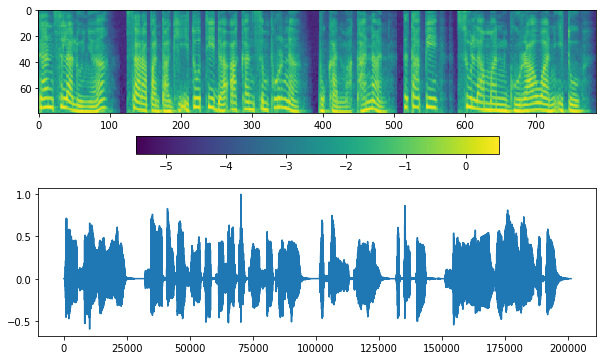

In [34]:
nrows = 2
fig, ax = plt.subplots(nrows = nrows, ncols = 1)
fig.set_figwidth(10)
fig.set_figheight(nrows * 3)
mel_outputs_ = np.reshape(r[1][k], [-1, 80])
im = ax[0].imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax[0])
ax[1].plot(r[0][k])
plt.show()

In [31]:
for k in range(20):
    print(r[2][k][0])

mera bulbul sudah akhir juga , dengar bunyi gelas ,
di rumah zarina ibu nahida , asap sabutnya menebal ,
hatinya berkata , bagaimana , kalau nasi dah ,
oi , kau ndak minum apa .
semakin mengancam nya , satu ancaman , yang diyakininya , akan berkesan buruk ,
kemudian bintang - bintang terkelip - kelip , kemudian wajah - wajah orang pula , sunarto nahida ,
dan dia merasa , dirinya begitu beruntung , kerana selain katijah , ada juga orang lain , yang benar - benar melihat perkembangan dirinya ,
dan selalunya , sarapan pagi itu tidak akan sempurna , bukan makanan , tetapi , sulaman gurauan itu ,
tanya macam tak bersemangat , orang yang hendak tolong dapatkan kita rumah , mesti berani ,
tanah idah juga dileteri zarina , tapi dia tetap juga berterus - terusan dimarahi dan dileteri ,
dah habis semuanya i dah , tanya zarina ,
baju kemeja tangan panjang dan bersongkok terperosok ke dalam , sampai ke paras keningnya , sedang menurunkan periuk bubur , yang sudah tinggal ,
begitu cinema kopek dice

In [35]:
import mp

audios, mels, text_ids, f0s, energies, pitches = [], [], [], [], [], []

In [36]:
for i in range(0, len(txts), 1000):
    index = min(i + 1000, len(txts))
    b = txts[i: index]
    results = mp.multiprocessing(b, process, cores = 10, returned = True)
    for result in results:
        audios.extend(result[0])
        mels.extend(result[1])
        text_ids.extend(result[2])
        f0s.extend(result[3])
        energies.extend(result[4])
        pitches.extend(result[5])

 28%|██▊       | 28/100 [00:15<00:32,  2.24it/s]

skipped


 27%|██▋       | 27/100 [00:05<00:12,  5.75it/s]

skipped


 37%|███▋      | 37/100 [00:09<00:12,  5.01it/s]

skipped


 80%|████████  | 80/100 [00:16<00:03,  5.43it/s]

skipped


 73%|███████▎  | 73/100 [00:17<00:07,  3.70it/s]

skipped


 10%|█         | 10/100 [00:02<00:21,  4.17it/s]

skipped


 39%|███▉      | 39/100 [00:08<00:16,  3.72it/s]

skipped


 25%|██▌       | 25/100 [00:05<00:15,  4.69it/s]

skipped


 32%|███▏      | 32/100 [00:08<00:18,  3.71it/s]

skipped


 30%|███       | 30/100 [00:07<00:13,  5.03it/s]

skipped


 81%|████████  | 81/100 [00:20<00:05,  3.73it/s]

skipped


 35%|███▌      | 35/100 [00:08<00:15,  4.21it/s]

skipped


 58%|█████▊    | 58/100 [00:12<00:07,  5.35it/s]

skipped


  1%|          | 1/100 [00:00<00:46,  2.13it/s]

skipped


  8%|▊         | 8/100 [00:02<00:28,  3.22it/s]]

skipped


 55%|█████▌    | 55/100 [00:13<00:08,  5.59it/s]

skipped


 59%|█████▉    | 59/100 [00:14<00:09,  4.22it/s]

skipped


 96%|█████████▌| 96/100 [00:21<00:01,  3.47it/s]

skipped


 32%|███▏      | 32/100 [00:08<00:18,  3.64it/s]

skipped


 47%|████▋     | 47/100 [00:10<00:12,  4.19it/s]

skipped


 82%|████████▏ | 82/100 [00:19<00:03,  5.10it/s]

skipped


 96%|█████████▌| 96/100 [00:22<00:00,  4.41it/s]

skipped


 62%|██████▏   | 62/100 [00:15<00:09,  4.16it/s]

skipped


 70%|███████   | 70/100 [00:17<00:06,  4.51it/s]

skipped


  8%|▊         | 8/100 [00:02<00:23,  3.84it/s]

skipped


 38%|███▊      | 38/100 [00:09<00:14,  4.21it/s]

skipped


 43%|████▎     | 43/100 [00:10<00:15,  3.58it/s]

skipped


 77%|███████▋  | 77/100 [00:18<00:04,  5.16it/s]

skipped


 33%|███▎      | 33/100 [00:08<00:16,  4.10it/s]

skipped


  8%|▊         | 8/100 [00:02<00:28,  3.21it/s]]

skipped


 47%|████▋     | 47/100 [00:12<00:14,  3.58it/s]

skipped


 87%|████████▋ | 87/100 [00:20<00:03,  3.79it/s]

skipped


 93%|█████████▎| 93/100 [00:21<00:01,  4.42it/s]

skipped


 64%|██████▍   | 64/100 [00:14<00:07,  4.51it/s]

skipped


 77%|███████▋  | 77/100 [00:18<00:05,  4.18it/s]

skipped


100%|██████████| 4/4 [00:00<00:00,  7.26it/s]


In [37]:
# scaler_mel = StandardScaler(copy=False)
# scaler_energy = StandardScaler(copy=False)
# scaler_f0 = StandardScaler(copy=False)
# scaler_pitch = StandardScaler(copy=False)

# for mel, f0, energy, pitch in zip(mels, f0s, energies, pitches):

#     scaler_mel.partial_fit(mel)
#     scaler_energy.partial_fit(energy[energy != 0].reshape(-1, 1))
#     scaler_f0.partial_fit(f0[f0 != 0].reshape(-1, 1))
#     scaler_pitch.partial_fit(pitch[pitch != 0].reshape(-1, 1))

In [39]:
len(mels)

38096

In [40]:
stats = np.load('/home/husein/speech-bahasa/female-stats-v3/stats.npy')
stats.shape

(2, 80)

In [41]:
scaler_mel = StandardScaler()
scaler_mel.mean_ = stats[0]
scaler_mel.scale_ = stats[1]

In [42]:
for i in tqdm(range(len(mels))):
    mels[i] = scaler_mel.transform(mels[i])

100%|██████████| 38096/38096 [00:07<00:00, 4808.20it/s]


In [43]:
# directory_stats = 'female-stats-v3'

In [44]:
# def save_statistics_to_file(scaler_list, config):
#     os.system(f'mkdir {directory_stats}')
#     for scaler, name in scaler_list:
#         stats = np.stack((scaler.mean_, scaler.scale_))
#         np.save(
#             os.path.join(f"{directory_stats}/stats{name}.npy"),
#             stats.astype(np.float32),
#             allow_pickle=False,
#         )

In [45]:
# scaler_list = [(scaler_mel, ""), (scaler_energy, "_energy"), (scaler_f0, "_f0"),
#               (scaler_pitch, "_pitch")]
# save_statistics_to_file(scaler_list, config)

In [46]:
directory = 'output-female-v4'

In [47]:
!rm -rf {directory}

In [48]:
os.system(f'mkdir {directory}')
directories = ['audios', 'mels', 'text_ids', 'f0s', 'energies', 'pitches']
for d in directories:
    os.system(f'mkdir {directory}/{d}')

In [49]:
for i in tqdm(range(len(mels))):
    np.save(f'{directory}/audios/{i}.npy', audios[i])
    np.save(f'{directory}/mels/{i}.npy', mels[i])
    np.save(f'{directory}/text_ids/{i}.npy', text_ids[i])
    np.save(f'{directory}/f0s/{i}.npy', f0s[i])
    np.save(f'{directory}/energies/{i}.npy', energies[i])
    np.save(f'{directory}/pitches/{i}.npy', pitches[i])

100%|██████████| 38096/38096 [04:04<00:00, 155.80it/s]


In [50]:
!rm -rf output-female-v3